## Rapidly Prototyping a Machine Learning Pipeline

The purpose of this workshop is to show how easy it is to take an idea and turn it into a successful Machine Learning application.

**Front Matter**: See the [README.md](README.md) file for environment setup concerns. This is a [Jupyter Notebook](https://jupyter.org/) -- an interactive computing environment that's popular in the Python community. Essentially, we can run and re-run cells of code to iteratively explore a data set.

In [ ]:
# this cell will (ideally) install NLTK
# and download the english stopwords.
!pip install nltk
import nltk
nltk.download('stopwords')

In [18]:
import pandas as pd
pd.options.display.max_colwidth = 0

import matplotlib
%matplotlib inline

# this is a trick to parallelize our computations
import multiprocessing
NCPUS = 8 if multiprocessing.cpu_count() > 8 else (multiprocessing.cpu_count() - 1)

### Part 1: The idea/loading data
In line with Tuesday's panel around "autocoders," we'll demonstrate how to use text descriptions to predict codes. Along the way, we'll show some good practice when practicing machine learning. While this notebook will focus on coding products using descriptions, this approach should work for many scenarios where one has a dataset with both text descriptions and their associated codes.

#### The data
This data comes from Census' own Foreign Trade site: https://www.census.gov/foreign-trade/schedules/b/index.html#download

Specifically, this is the "concordance file" for the Harmonized System's import/export codes. This gives us the code and a description of what products fit into that code: perfect for the sort of automatic coding we want to do. We've included the file here (in the `data/` subfolder) for ease-of-use.

The import and export codes are slightly different at the 10-digit level; however, the codes are heirarchical and at the 6-digit level they are the same (as defined by an international standards group). We'll model at an even less granular level than that - the 4-digit level - based on the amount of data that we have.

First, let's take a look in a text editor. Jupyter has one that's enough for this.

From here, taking a look at the `imp-stru.txt` file will give us the "schema."

For the purposes of this workshop, we'll aim to manipulate data exclusively in [Pandas](https://pandas.pydata.org/) -- a fully-featured and quite powerful tabular data analysis library for Python -- to keep things more consistent. Howevever, you could just as easily do this in a combination of "pure python" + Pandas.

First, let's load up one of the files and see what it looks like in Pandas. In general, Pandas makes it easy to read in common file types such as `csv` and `xlsx`. In this case, the file type is slightly different, so we'll have to manually process based on the schema we've been given. Luckily, this is pretty easy in Pandas.

In [28]:
# here, we will use the general 'read_table' convenience function.
# however, two more common ones are 'pd.read_csv' and 'pd.read_xlsx'
df1 = pd.read_table("data/imp-code.txt")

# an easy way to show the first few rows of a data set.
# by default, the Jupyter Notebook shows the output of the last command you ran.
df1.head()


,"0101210010 HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE NO 00150 12060 0 112920 00"
0,"0101210020 HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE NO 00150 12060 0 112920 00"
1,"0101290010 HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING NO 00150 00100 0 112920 00"
2,"0101290090 HORSES, LIVE, NESOI HORSES, LIVE, NESOI NO 00150 12060 0 112920 00"
3,"0101300000 ASSES, LIVE ASSES, LIVE NO 00150 12060 0 112920 00"
4,"0101903000 MULES AND HINNIES, FOR IMMEDIATE SLAUGHTER, LIVE MULES AND HINNIES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE NO 00150 00100 0 112920 00"


In [29]:
# the first row is incorrectly inferred to be the header. This is easy
# to fix with a parameter to the read_table function
df1 = pd.read_table("data/imp-code.txt", header=None, names=['all_text'])
df1.head()

,all_text
0,"0101210010 HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE NO 00150 12060 0 112920 00"
1,"0101210020 HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE NO 00150 12060 0 112920 00"
2,"0101290010 HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING NO 00150 00100 0 112920 00"
3,"0101290090 HORSES, LIVE, NESOI HORSES, LIVE, NESOI NO 00150 12060 0 112920 00"
4,"0101300000 ASSES, LIVE ASSES, LIVE NO 00150 12060 0 112920 00"


In [30]:
# now, we only have 1 column. 
# we want to break this out into separate columns based on our schema. 
# this is easy to do with Pandas...
df1["HS10"] = df1["all_text"].str[:10]
df1["long_desc"] = df1["all_text"].str[69:219]
df1.head()

,all_text,HS10,long_desc
0,"0101210010 HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE NO 00150 12060 0 112920 00",0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE"
1,"0101210020 HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE NO 00150 12060 0 112920 00",0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE"
2,"0101290010 HORSES, FOR IMMEDIATE SLAUGHTER, LIVE, NESOI HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING NO 00150 00100 0 112920 00",0101290010,"HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING"
3,"0101290090 HORSES, LIVE, NESOI HORSES, LIVE, NESOI NO 00150 12060 0 112920 00",0101290090,"HORSES, LIVE, NESOI"
4,"0101300000 ASSES, LIVE ASSES, LIVE NO 00150 12060 0 112920 00",0101300000,"ASSES, LIVE"


In [31]:
# great. Now let's get rid of the initial column
# since we've put all we care about into separate columns.
del df1["all_text"]

In [32]:
# last, let's repeat this for the other file.

df2 = pd.read_table("data/exp-code.txt", header=None, names=['all_text'])
df2["HS10"] = df2["all_text"].str[:10]
df2["long_desc"] = df2["all_text"].str[69:219]
del df2["all_text"]

# and we have our final output
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,HS10,long_desc
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE"
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE"
2,0101290010,"HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING"
3,0101290090,"HORSES, LIVE, NESOI"
4,0101300000,"ASSES, LIVE"


Now, let's look at some metadata...

In [33]:
print("df has", len(df), "rows")
print("df has", df['HS10'].nunique(), 'unique HS 10-digit codes')
df.head()

df has 28469 rows
df has 22660 unique HS 10-digit codes


,HS10,long_desc
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE"
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE"
2,0101290010,"HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING"
3,0101290090,"HORSES, LIVE, NESOI"
4,0101300000,"ASSES, LIVE"


Great. We have something like 28,000 rows. As we can immediately see, there is some overlap between the 10-digit import and export codes, hence the only ~22,000 unique 10-digit codes. It is likely that duplicate codes have the same description in both files... and from the perspective of the model, 2 copies of the same description/code is just as good as 1, so we'll only want to retain one copy of those. Additionally, we need to standardize and process this text, which will probably leave us with more of duplicate text strings as well. Let's start processing and find out.

#### Part 2: Cleaning / processing the data

There are a number of popular libraries for processing text in Python. In this case, we'll use `nltk`, but for reference `spaCy` is another very good option.

Additionally, depending on the type of text that you have, there are many different ways to process and "extract features" (i.e. create variables for modelling) from that text. For example, if you're working with phrases/sentences, spaCy has good tools for determining which part-of-speech each word in a sentence maps to.

In our case, we have very simple product descriptions (perhaps closer to "tags" than sentences). Plus, they have been officially written and are relatively standardized. As a result, less processing is required. We'll start out by using regular expressions. This is a good tutorial to learn more about those: https://www.datacamp.com/community/tutorials/python-regular-expression-tutorial

We could also use NLTK's "tokenizer", but this is overkill for such simple descriptions.

Last, we'll show off the same common workflow we began above - using one column to derive another, processed column in Pandas. [This link](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html) shows off some of Pandas' built-in string processing functionality -- essentially, everything you an access by using `df[col_name].str` .

In [34]:
# we'll do this step-by-step, to illustrate
df['long_stripped'] = df['long_desc'].str.strip()

# this is pulling 3 random rows, instead of the top 5, just for some variety
# note the new colummn
df.sample(3)

,HS10,long_desc,long_stripped
13946,7409290050,"BRASS PLATES, SHEET AND STRIP, NOT COILED, THCKNESS OF OVER 0.15 BUT LESS THAN 5MM, WITH WIDTH OF 500MM OR M0RE","BRASS PLATES, SHEET AND STRIP, NOT COILED, THCKNESS OF OVER 0.15 BUT LESS THAN 5MM, WITH WIDTH OF 500MM OR M0RE"
27426,8540110080,"CATHODE-RAY TELEVISION PICTURE TUBES, COLOR, HAVING A VIDEO DISPLAY DIAGONAL EXCEEDING 67 CM (26 INCHES)","CATHODE-RAY TELEVISION PICTURE TUBES, COLOR, HAVING A VIDEO DISPLAY DIAGONAL EXCEEDING 67 CM (26 INCHES)"
26184,8436100000,MACHINERY FOR PREPARING ANIMAL FEEDS,MACHINERY FOR PREPARING ANIMAL FEEDS


In [35]:
df['long_lower'] = df['long_stripped'].str.lower()

df.head(2)

,HS10,long_desc,long_stripped,long_lower
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","horses and asses, purebred breeding, male, live"
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","horses and asses, purebred breeding, female, live"


In [36]:
import re
# this is in general one of the more useful regular expressions to know
# the '\w' searches for word-like tokens, and the '+' says "one or more"
# combined, this gets us 'one or more characters', i.e. word tokens w/o commas, spaces, etc.
WORD_REGEX = r'\w+'


# first, to illustrate
re.findall(WORD_REGEX, "horses and asses, purebred breeding, male, live")

['horses', 'and', 'asses', 'purebred', 'breeding', 'male', 'live']

In [37]:
# there's a fair bit going on here. 
# first, we define a function that works on an individual
# description.
def find_words(desc):
    return re.findall(WORD_REGEX, desc)

# then, we 'apply' that function to a column, which 
# means that we call this function on every cell within
# the column.
df['long_word_list'] = df['long_lower'].apply(find_words)

# now, combine the list of words back into a clean string
df['long_words_only'] = df['long_word_list'].str.join(' ')

df.head()

,HS10,long_desc,long_stripped,long_lower,long_word_list,long_words_only
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE","horses and asses, purebred breeding, male, live","[horses, and, asses, purebred, breeding, male, live]",horses and asses purebred breeding male live
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE","horses and asses, purebred breeding, female, live","[horses, and, asses, purebred, breeding, female, live]",horses and asses purebred breeding female live
2,0101290010,"HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING","HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING","horses, imported for immediate slaughter, live, except purebred breeding","[horses, imported, for, immediate, slaughter, live, except, purebred, breeding]",horses imported for immediate slaughter live except purebred breeding
3,0101290090,"HORSES, LIVE, NESOI","HORSES, LIVE, NESOI","horses, live, nesoi","[horses, live, nesoi]",horses live nesoi
4,0101300000,"ASSES, LIVE","ASSES, LIVE","asses, live","[asses, live]",asses live


To clean things up a bit, let's get rid of some of these intermediate columns.

In practice, this is a useful thing to do because it will free up memory. If you find your code is using too much memory or is running very slow, then consider deleting unnecessary columns in this manner.

In [38]:
# running this cell more than once will cause an error
# because when you try to delete somethat that has 
# already been deleted, it's no longer there
del df['long_stripped']
del df['long_lower']
del df['long_word_list']

df.head()

,HS10,long_desc,long_words_only
0,0101210010,"HORSES AND ASSES, PUREBRED BREEDING, MALE, LIVE",horses and asses purebred breeding male live
1,0101210020,"HORSES AND ASSES, PUREBRED BREEDING, FEMALE, LIVE",horses and asses purebred breeding female live
2,0101290010,"HORSES, IMPORTED FOR IMMEDIATE SLAUGHTER, LIVE, EXCEPT PUREBRED BREEDING",horses imported for immediate slaughter live except purebred breeding
3,0101290090,"HORSES, LIVE, NESOI",horses live nesoi
4,0101300000,"ASSES, LIVE",asses live


#### Part 3: Initial Model
Now that we've gotten English words only, we can try a simple model. Let's get into the modelling approach and the package that we'll use to implement it, `scikit-learn`. Pandas is a "batteries-included" data analysis library -- you can do a large number of data analysis tasks without writing "pure" python and exclusively staying within Pandas' programming interface. 

Somewhat more frequently, scikit-learn requires you to plug in some batteries... but it does play nice with Pandas and overall works very well, however. Furthermore, it is a remarkably comprehensive library that includes a large number of tools for preprocessing your data, selecting and extracting important variables (in the machine learning parlance, "features"), and models to try out. Last, it provides a clean and mostly consistent interface, which makes experimenting significantly easier.

We'll be implementing a _bag-of-words_ model. The idea is very simple: each word becomes a separate variable. For each variable, the value is the number of times that word occurs in that particular record. Let's demonstrate with a quick example.

In [39]:
# let's try this process on the first two and see what we get back
first_few_only = df.head(2)
first_few_only['long_words_only']

0    horses and asses purebred breeding male live  
1    horses and asses purebred breeding female live
Name: long_words_only, dtype: object

In [40]:
# scikit-learn calls this process "vectorizing", i.e. turning a sentence into a vector of variables.
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
# this will actually convert our first few descriptions into vectors
tfd = cv.fit_transform(first_few_only['long_words_only'])
# by default, it's a sparse matrix
tfd.toarray()

array([[1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1]], dtype=int64)

For explainability, let's cleanly present this mapping:

In [41]:
# don't worry about this, it's for pedagogical purposes
columns = [x[0] for x in sorted(list(cv.vocabulary_.items()), key=lambda x: x[1])]
pd.DataFrame(tfd.toarray(), columns=columns, index=first_few_only['long_words_only'])

,and,asses,breeding,female,horses,live,male,purebred
long_words_only,,,,,,,,
horses and asses purebred breeding male live,1,1,1,0,1,1,1,1
horses and asses purebred breeding female live,1,1,1,1,1,1,0,1


Now that we get the idea, let's do this for the entire dataset and see what it looks like.

In [42]:
cv = CountVectorizer()
cv.fit_transform(df["long_words_only"])

<28469x12054 sparse matrix of type '<class 'numpy.int64'>'
	with 347471 stored elements in Compressed Sparse Row format>

We won't try to convert this into an array as above, because it would be very memory-intensive. But we can see we have 12,054 unique words.

Now, we have features (i.e. input variables). But what what exactly are we going to model? The trade-off is that the more digits of the HS code we use, the fewer records there are within each code that the model can learn from. We aren't using any heirarchical information here, so each HS code is a completely separate category from the model's perspective. Let's extract 2-digit, 4-digit, and 6-digit harmonized codes in our DataFrame.

,HS2
count,98.000000
mean,290.500000
std,411.851396
min,2.000000
25%,85.250000
50%,160.000000
75%,307.500000
max,2904.000000


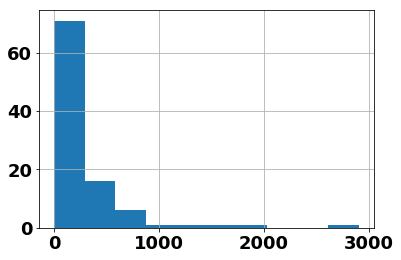

In [43]:
df["HS2"] = df["HS10"].str[:2]
df["HS4"] = df["HS10"].str[:4]
df["HS6"] = df["HS10"].str[:6]

# we'll look at the distribution of # of records in each class at the 2-digit level.
# Remember, we haven't de-duplicated, so this estimate is a bit high
df.HS2.value_counts().hist()
df.HS2.value_counts().describe().to_frame()

A median category size of 160 is workable, but not huge. How useful this is depends on how consistent your text data is. In the case of these descriptions, it should be good enough. But in the case of real-world product descriptions, you generally want more per category, to capture the wide variety of language choice and industry jargon. In other applications, less text may be alright. Disaggregating the codes into 4-digit or beyond will make this worse. So, we'll stick with 2-digit.

With that said, we see that some categories do have only 2 descriptions. Let's see how many there are:

In [44]:
vcs = df.HS2.value_counts()
print(len(vcs[vcs == 2]), "codes with only 2 descs")
vcs[vcs == 2]

1 codes with only 2 descs


99    2
Name: HS2, dtype: int64

Chapter 99 looks to be a very specific category, so we'd probably want to think more carfeully before classifying those. Going forward, we'll remove them.


#### Training / test sets
As a bare minimum, we need at least 2 records in any category we want to attempt to model. This is because we need to split our data into two pieces: the _training set_, which we'll develop the model on, and the _test set_, which we'll subsequently evaluate it on. We want to see how the model performs on descriptions it's never seen before. In practice, we almost certainly want more than 2. At least 3.

In addition, validation sets and [_cross validation_](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6), which we may be able to get into today, is an important technique in machine learning that helps us avoid "overfitting" the model to the sample of data we're using and the particular split of training/test data that we create. It's easy to do in python with `scikit-learn`.

**Reusable components**

As we begin to model and explore different techniques, we'll essentially repeat 3 steps:
1. Develop features
2. Train a model with those features
3. Evaluate 

In theory, we could change any of these (evaluation metric, specific input features used, or the model)... but today, we'll focus on 1. and 2. . In order to make life easier, we'll set up a couple of reusable functions that we can call with different parameters. This will make exploring different modelling approaches easier, as we can stay organized and keep track of what we've done, what we've tried, etc. - while it's a small cost up front, I'd highly recommend doing this in your own workflow.

Just below, I also wrote a function to split the training/test data (stratified), which would make it easy to try this approach with 4-digit, 6-digit, or larger codes.

In [45]:
from sklearn.model_selection import train_test_split

# we make these functions so we can easily modify or reuse them later
def make_test_train(df, y_column):
    # first, let's remove duplicates
    print("initially, we have", len(df), "records")
    deduped = df.drop_duplicates(subset=["long_words_only"])
    print("after deduping, we have", len(deduped), "records")

    #now, let's remove any HS4 category with <2 records
    vcs = deduped[y_column].value_counts()
    to_include = vcs[vcs > 2].index
    final_dataset = deduped[deduped[y_column].isin(to_include)]
    print("after removing <3 record categories, there are", len(final_dataset), "records")

    # the stratify is important -- 
    # it's making sure that we have an instance of each category in both the train and test sets

    train, test = train_test_split(final_dataset, stratify=final_dataset[y_column], 
                                   random_state=42, )
    print("training set has", len(train), "records --", 100 * len(train) / len(final_dataset), 
          "percent -- and test set has", len(test), "records")
    
    return train, test

train, test = make_test_train(df, "HS2")

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records


Now that we've split up our data, we can choose a classifier. We'll use one of the simplest out there: [Logistic Regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc), often known as "logit." Normally, logistic regression is a binary classifier. In our case, because we're categorizing  98 chapters (we dropped chapter 99), we'll actually be training 98 binary classifiers, and selecting the highest-probability prediction from those. This is known as "one-vs-all". There are other voting schemes to convert binary classifiers into multi-class classifiers.

One more trick: instead of using the typical solvers used for logistic regression, we'll use a heuristic optimization approach that runs more quickly and efficiently, called "stochastic gradient descent." SGD, as it's abbreviated, is part of the core technique used to optimize (the ever-trendy) neural networks (back-propagation or "backprop") as well. We'll leave it to you to convince yourself that this approach is just as good as a more involved optimization approach. You can get into the math or just try it out in Python/scikit-learn (look into the `LogisticRegression` class)!

In [46]:
from sklearn.linear_model import SGDClassifier

# here's one of those reusable functions I mentioned above
def make_model(train, vec, column_name, y_column, loss='log', alpha=.0001):
    # first, turn our words into a large matrix of 0s and 1s as demonstrated above
    X = vec.fit_transform(train[column_name])
    # pull out the thing we want to predict
    y = train[y_column]

    # instantiate a classifier. Note the 
    # hyperparameters, such as "penalty" and "loss."
    # We'll come back to those.
    clf = SGDClassifier(n_jobs=NCPUS, alpha=alpha, loss=loss,
                        penalty='l2', max_iter=5000, tol=1e-5,
                        random_state=42)
    
    # once we've specified what we want the classifier to look like
    # we call its 'fit' function to actually train a model.
    clf.fit(X, y)
    return clf, vec

clf, vec = make_model(train, CountVectorizer(), "long_words_only", "HS2")

Now we have a trained model in the `clf` variable. We also need to keep the "trained" vectorizer (i.e. the mapping of words to columns) in a variable, `vec`. Let's see how it does on a simple metric: overall accuracy. That is, "out of every code the model predicted, what fraction did it get right?"

In [47]:
def evaluate_model(clf, vec, train, test, column_name, y_column):
    # first, again extract the feature matrix for the training set
    X = vec.transform(train[column_name])
    y = train[y_column]
    # now, extract feature matrix for test set.
    # note that unknown words simply do not get mapped,
    # which we'll see below
    X_test = vec.transform(test[column_name])
    
    # this is how we actually use the model to 
    # predict outputs based on inputs
    y_test_pred = clf.predict(X_test)
    # and, we will compare to the actual labels in the test set
    y_test_true = test[y_column]
    
    # last, we'll want to look at how well the model does on the training
    # set as well, so let's predict those too.
    y_train_pred = clf.predict(X)
    print("in-sample accuracy: ", (y_train_pred == y).mean())
    print("test set accuracy: ", (y_test_pred == y_test_true).mean())
    return y_test_true, y_test_pred
    
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

in-sample accuracy:  0.970137688502116
test set accuracy:  0.9116753084212408


Not bad! 

It's worth noting that here we include the accuracy on the training set ("in-sample") and test set in order to diagnose overfitting. If the performance on the training set is dramatically better than the performance on the test set, it's often a sign that the model is learning "the wrong things" from the training data. 

This is an especially common problem in text processing, where we have a model that uses a large number of varialbes (1 per word, in the case of this initial model). This is sometimes called the "curse of dimensionality." We'll look more at this and discuss a commonly used strategy later.

Now, we can drill down a bit in a few ways. A productive way to do so is to look at poorly performing codes.

In [48]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

print(classification_report(y_test_true, y_test_pred))

             precision    recall  f1-score   support

         01       0.92      1.00      0.96        22
         02       0.96      0.98      0.97        53
         03       0.95      0.98      0.96       158
         04       0.92      0.96      0.94        74
         05       1.00      0.42      0.59        12
         06       1.00      0.87      0.93        15
         07       0.97      1.00      0.98        85
         08       0.92      0.96      0.94        57
         09       0.95      0.82      0.88        22
         10       0.94      0.84      0.89        19
         11       0.76      0.93      0.84        14
         12       0.81      0.90      0.85        42
         13       1.00      0.14      0.25         7
         14       1.00      0.75      0.86         4
         15       0.96      0.87      0.91        30
         16       0.91      0.77      0.83        56
         17       0.96      0.96      0.96        26
         18       0.92      0.96      0.94   

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Looking at codes with >= 100 samples can see chapter 29 is performing poorly. Let's investigate.

In [49]:
test_reset = test.reset_index() # this is an unfortunate pandas thing 
test_reset["pred"] = y_test_pred # add a column that is our predicted values from above

# this is the syntax for queries in pandas
# | is for the boolean "OR", == is roughly "WHERE x=y", and != is "WHERE x!=y"
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])

cols = ["long_words_only", "HS2", "pred"] # just specifying the columns to view
test_reset[cond1 & cond2][cols]

,long_words_only,HS2,pred
57,bauxite calcined refractory grade,26,29
60,toluene,27,29
61,quebracho extract,32,29
126,imitation gemstones,39,29
169,trisodium phosphate,28,29
190,nuclear reactors,84,29
226,flashlights,85,29
229,nitric acid and sulfonitric acids,28,29
243,peptones and their derivatives other protein substances and their derivatives and hide powder whether or not chromed nesoi,35,29
302,golf clubs complete,95,29


What's going on here? There doesn't appear to be much of a pattern here. It's likely that 29 is the "default" prediction. This makes sense, because the category is both large and full of obscure chemical words. The model can likely figure out other chapters more easily, so it's a smart strategy to, upon seeing an unknown word, pick the category with the largest variety of complex words. We can test this as follows:

In [50]:
# let's get the vector for a word the model has never seen before -- it's all zeroes
x = vec.transform(["thiswordisgibberish"])
# then, we'll run it through the model
clf.predict(x)

array(['29'], dtype='<U2')

In [51]:
# equivalently, we can see which of the intercept terms is largest.
# this will always be the default prediction in the absence of known words.
clf.classes_[clf.intercept_.argmax()]

'29'

So it seems this intuition is correct.

One interesting result is that "racquetball rackets" gets predicted to code 29. What's going on there? Let's check out the training set to see how frequently the words "racquetball" and "racket" occurred.

In [52]:
train[train["long_words_only"].str.contains("racket")
      | train["long_words_only"].str.contains("racquetball")]

,HS10,long_desc,long_words_only,HS2,HS4,HS6
17348,8708806510,"BEAM HANGER BRACKETS FOR SUSPENSION SYSTEMS, NESOI, OF THE MOTOR VEHICLES OF HEADING 8701 - 8705",beam hanger brackets for suspension systems nesoi of the motor vehicles of heading 8701 8705,87,8708,870880
18793,9506516000,PARTS AND ACCESSORIES FOR LAWN-TENNIS RACKETS,parts and accessories for lawn tennis rackets,95,9506,950651
18791,9506512000,"LAWN-TENNIS RACKETS, STRUNG",lawn tennis rackets strung,95,9506,950651
18792,9506514000,"LAWN-TENNIS RACKETS, NOT STRUNG",lawn tennis rackets not strung,95,9506,950651
14524,8302500000,"HAT-RACKS, HAT PEGS, BRACKETS AND SIMILAR FIXTURES, AND PARTS THEREOF, OF BASE METAL",hat racks hat pegs brackets and similar fixtures and parts thereof of base metal,83,8302,830250
18798,9506598060,"RACKETS WHETHER OR NOT STRUNG, INCLUDING PARTS AND ACCESSORIES, NESOI",rackets whether or not strung including parts and accessories nesoi,95,9506,950659
28360,9506511000,"LAWN-TENNIS RACKETS, WHETHER OR NOT STRUNG",lawn tennis rackets whether or not strung,95,9506,950651
18728,9405916040,"LAMPS PARTS, PRISMS AND OTHER GLASS ARTICLES OF A KIND USE IN CHANDELIERS AND WALL BRACKETS, AND ARTICLES THEREOF",lamps parts prisms and other glass articles of a kind use in chandeliers and wall brackets and articles thereof,94,9405,940591
18794,9506594040,BADMINTON RACKETS AND RACKET FRAMES,badminton rackets and racket frames,95,9506,950659
18822,9506991200,"BADMINTON ARTICLES AND EQUIPMENT EXCEPT RACKETS AND PARTS AND ACCESSORIES THEREOF, NESOI",badminton articles and equipment except rackets and parts and accessories thereof nesoi,95,9506,950699


"Racquetball" isn't there, but "racket" is, and we'd hope that would be enough information (it certainly is for a human). It may be the case that some of these other words are polluting the model's ability to grasp the importance of the word racket. Let's remove some of them using a common NLP technique. The idea is that we want to remove some of the most commonly occurring words immediately.

In [53]:
from nltk.corpus import stopwords
all_stopwords = set(stopwords.words('english'))
all_stopwords.add("nesoi")
all_stopwords.add("excluding")
all_stopwords.add("except")
all_stopwords.add("including")
all_stopwords.add("thereof")
all_stopwords.add("parts")
all_stopwords.add("accessories")
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [54]:
def remove_stopwords(desc):
    return " ".join(d for d in desc.split() if d not in all_stopwords)
df["long_no_stopwords"] = df["long_words_only"].apply(remove_stopwords)

In [55]:
train, test = make_test_train(df, "HS2")
# because of how we coded the function above, we just specify that we want to use
# a different column name for the input text
clf, vec = make_model(train, CountVectorizer(binary=True), "long_no_stopwords", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords", "HS2")

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.9597067413721165
test set accuracy:  0.9050598962989451


Perhaps marginally worse performance, but with a decrease this small, this could simply be a function of the random train/test split we chose. Without further investigation, I'd say this had no improvement either way on this dataset. As compared with other text-based datasets, this may be a result of the fact that these descriptions are more standardized and direct than typical text data, so there aren't really a ton of stopwords.

In [56]:
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

,long_no_stopwords,HS2,pred
364,squash rackets,95,29
5425,racquetball rackets,95,29


And indeed, we still see that the "racquetball rackets" description is mispredicted in the exact same way. 

Something else we can try is "stemming" -- the idea is, we want to exploit the fact that english words that convey the same meaning can have different suffixes. There are a number of approaches to stemming. For example, maybe if we turn all instances of "rackets" to the standardized "racket", we'll see some improvement.

In [59]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
def stem_words(desc):
    return " ".join(stemmer.stem(x) for x in desc.split())

df["long_no_stopwords_stemmed"] = df["long_no_stopwords"].apply(stem_words)
train, test = make_test_train(df, "HS2")
train[train["long_no_stopwords_stemmed"].str.contains("racket")]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records


,HS10,long_desc,long_words_only,HS2,HS4,HS6,long_no_stopwords,long_no_stopwords_stemmed
17348,8708806510,"BEAM HANGER BRACKETS FOR SUSPENSION SYSTEMS, NESOI, OF THE MOTOR VEHICLES OF HEADING 8701 - 8705",beam hanger brackets for suspension systems nesoi of the motor vehicles of heading 8701 8705,87,8708,870880,beam hanger brackets suspension systems motor vehicles heading 8701 8705,beam hanger bracket suspens system motor vehicl head 8701 8705
18793,9506516000,PARTS AND ACCESSORIES FOR LAWN-TENNIS RACKETS,parts and accessories for lawn tennis rackets,95,9506,950651,lawn tennis rackets,lawn tenni racket
18791,9506512000,"LAWN-TENNIS RACKETS, STRUNG",lawn tennis rackets strung,95,9506,950651,lawn tennis rackets strung,lawn tenni racket strung
18792,9506514000,"LAWN-TENNIS RACKETS, NOT STRUNG",lawn tennis rackets not strung,95,9506,950651,lawn tennis rackets strung,lawn tenni racket strung
14524,8302500000,"HAT-RACKS, HAT PEGS, BRACKETS AND SIMILAR FIXTURES, AND PARTS THEREOF, OF BASE METAL",hat racks hat pegs brackets and similar fixtures and parts thereof of base metal,83,8302,830250,hat racks hat pegs brackets similar fixtures base metal,hat rack hat peg bracket similar fixtur base metal
18798,9506598060,"RACKETS WHETHER OR NOT STRUNG, INCLUDING PARTS AND ACCESSORIES, NESOI",rackets whether or not strung including parts and accessories nesoi,95,9506,950659,rackets whether strung,racket whether strung
28360,9506511000,"LAWN-TENNIS RACKETS, WHETHER OR NOT STRUNG",lawn tennis rackets whether or not strung,95,9506,950651,lawn tennis rackets whether strung,lawn tenni racket whether strung
18728,9405916040,"LAMPS PARTS, PRISMS AND OTHER GLASS ARTICLES OF A KIND USE IN CHANDELIERS AND WALL BRACKETS, AND ARTICLES THEREOF",lamps parts prisms and other glass articles of a kind use in chandeliers and wall brackets and articles thereof,94,9405,940591,lamps prisms glass articles kind use chandeliers wall brackets articles,lamp prism glass articl kind use chandeli wall bracket articl
18794,9506594040,BADMINTON RACKETS AND RACKET FRAMES,badminton rackets and racket frames,95,9506,950659,badminton rackets racket frames,badminton racket racket frame
18822,9506991200,"BADMINTON ARTICLES AND EQUIPMENT EXCEPT RACKETS AND PARTS AND ACCESSORIES THEREOF, NESOI",badminton articles and equipment except rackets and parts and accessories thereof nesoi,95,9506,950699,badminton articles equipment rackets,badminton articl equip racket


In [60]:
clf, vec = make_model(train, CountVectorizer(), "long_no_stopwords_stemmed", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords_stemmed", "HS2")
test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

in-sample accuracy:  0.9573225248852596
test set accuracy:  0.9057750759878419


,long_no_stopwords,HS2,pred
364,squash rackets,95,29
5425,racquetball rackets,95,29


Again, no improvement. It's time to try some more involved methods.

Let's try something that frequently helps bag-of-words models: we'll include _bigrams_ instead of unigrams. Frequently, in the English language, pairs of words -- and their order -- have meaning. While it may not help in a situation like the "racquetball racket" issue, it may help in general.

In [62]:
train, test = make_test_train(df, "HS2")
clf, vec = make_model(train, CountVectorizer(ngram_range=(1, 2)), "long_words_only", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.9871848363831436
test set accuracy:  0.9234757732880386


,long_no_stopwords_stemmed,HS2,pred
364,squash racket,95,29
5425,racquetbal racket,95,29


We've bumped our performance up about a percentage from our previous best, so this is potentially worth keeping around. However, in addition, training set accuracy is up to nearly 99%. This may indicate we're overfitting. The reason? When we include both words and all bigram combinations, we now have significantly more variables...

In [63]:
vec.transform(train[:1]['long_words_only'])

<1x54462 sparse matrix of type '<class 'numpy.int64'>'
	with 37 stored elements in Compressed Sparse Row format>

Additionally, this still doesn't solve our issue of "racquetball racket." What's going on there? Something else that frequently helps models like these is _subword information_. Now, from each word, we're going to create features for all subwords of ranges 2-6 of that word. As an example, the subwords of length 3 for "racquetball" would be
- rac
- acq
- que
- uet
- etb
- bal
- all (where a special character differentiates the word "all" from the character sequence a-l-l)

Perhaps "rac" and "bal" will be enough to cue the model that these records should be in chapter 95.

In [65]:
from sklearn.pipeline import FeatureUnion
# without getting into the specifics of sklearn too much...
# a FeatureUnion allows us to engineer separate features then throw
# them all into a model. In this case, we'll continue using each word as 
# a feature, and also add in subwords of length 2-6
fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6)))], n_jobs=2)

train, test = make_test_train(df,  "HS2")
clf, vec = make_model(train, fu, "long_words_only", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.9994635512904572
test set accuracy:  0.9333094940103701


,long_no_stopwords_stemmed,HS2,pred


Hooray! We've fixed that particular issue. However, again, we see that we are currently 100% accurate. This strongly implies we are overfitting. Given the number of features, this is unsurprising...

In [67]:
vec.transform(train[:1])

<8x234357 sparse matrix of type '<class 'numpy.int64'>'
	with 115 stored elements in Compressed Sparse Row format>

We may be able to improve this situation by increasing our "regularization" parameter -- this term allows us to penalize weights that become especially large.

In [69]:
from sklearn.pipeline import FeatureUnion
fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6)))], n_jobs=2)

train, test = make_test_train(df, "HS2")

# to do this, we just add the alpha parameter here 
# (this is because we defined alpha as a modifiable parameter above)
clf, vec = make_model(train, fu, "long_words_only", "HS2", alpha=1e-3)
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")



test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.9965428860940574
test set accuracy:  0.9365278026104059


,long_no_stopwords_stemmed,HS2,pred


Looks about the same, but we'll keep this in mind going forward.

Another way we can deal with situations where certain words aren't being weighted heavily enough -- or others are being weighted too heavily -- by the model is to use a _feature scaling_ technique known as TF-IDF (term frequency - inverse document frequency). In essence, we're helping the model determine what features should be weighted and which ones should be ignored.

The idea with TF-IDF is that instead of weighting each word with a 1 or 0, depending on whether or not it's in that particular record, instead we'll weight with more contextual information. There are many TF-IDF schemes, but they essentially all boil down to this:

$$ 
\frac{\textrm{# times word occurs in record}}{\textrm{# unique records the word occurs in}}
$$

In other words, the less frequently a word occurs across the entire set of descriptions, the more important it presumably is. Thus, since we frequently see the term, "nesoi",  for example, we'll weight that less.

Let's go back to our baseline model, but using the `TfidfVectorizer` instead of the `CountVectorizer`

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

train, test = make_test_train(df, "HS2")
# the only change to our "formula" is in the below line. See how easy this is?
clf, vec = make_model(train, TfidfVectorizer(), "long_no_stopwords_stemmed", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords_stemmed", "HS2")

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.8786433808189784
test set accuracy:  0.8378330055426426


Looks like in the case of this dataset, TF-IDF does worse across the board. As with other common techniques (e.g. stemming) this gives us a sign that every word included in these descriptions is important -- compared to other natural language datasets, these descriptions are quite sparse, so this makes sense.

Because it's fun and we set ourselves up to easily do so earlier, let's try one last thing before switching gears for a final important concept. We've been using logistic regression up until now. One of the nice things about SGD is that it's also easy to implement a performant _Linear Support Vector Machine_ (SVM), simply by changing the loss function that we are performing SGD to optimize. The SVM can't necessarily "learn" fundamentally different relationships than the logit classifier can -- both are linear -- however, the way that it optimizes its binary classifiers ("maximum-margin") can sometimes lead to slightly better results.

Instead of 'log' loss, SGD uses 'hinge' loss. In the `make_model` function above, I included a parameter to modify the loss for ease-of-use

In [73]:
fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6)))], n_jobs=2)
train, test = make_test_train(df, "HS2")

# only change!
clf, vec = make_model(train, fu, "long_words_only", "HS2", loss='hinge')
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_words_only", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.9976753889253144
test set accuracy:  0.932415519399249


,long_no_stopwords_stemmed,HS2,pred


And indeed, we see the same results. 

At this point, you probably get the idea that it's pretty straightforward to go into the pandas/scikit-learn/nltk toolbox, pull out a technique, and plug it in to see how it improves your model. What if you want to do things a little bit more systematically, and make sure to squeeze every last drop of predictive power out of your data?

### Cross-validation and GridSearchCV

Up until now, we've looked at the "art" of feature extraction. We've seen a couple successful approaches and many unsuccessful ones to improve accuracy on our test set (this more-or-less reflects reality, most stuff you try doesn't work). However, we can actually systematize finding the best combination of tricks that we've tried by having the computer try every single combination of them. Scikit-learn calls this concept "grid search". 

If we did this with just a train/test set, we'd risk "overfitting" by simply finding the model that happens to work best on this particular test set. As such, while undertaking this process, we will further divide our training set into "training" and "validation" sets, which we'll randomly shuffle as we go along. Then, once we've determined the best model, we'll see how it performs on the test set we've been holding out this whole time.

Above, we mentioned "cross validation" -- this is exactly that! Here's a handy diagram:
<img src="https://cdn-images-1.medium.com/max/1600/1*rgba1BIOUys7wQcXcL4U5A.png" style="height: 400px;" />

In order to do this cleanly, we'll need to get a bit fancier with scikit-learn as well. But, as with many things, scikit-learn does offer this functionality out-of-the-box, provided you write your code to conform to its interface.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# pipelines are another useful abstraction provided by scikit-learn
pipe = Pipeline([('features', CountVectorizer()),
                  ('clf', SGDClassifier())])

fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6)))])

# this specifies that we will try all of the productive feature extraction techniques
# including a combination we didn't try above: words, bigrams, and sub-character features
possible_features = [CountVectorizer(ngram_range=(1, 2)),
                     fu]

# this now specifies all of the combinations of things we want to try
# note we've included the log loss vs. hinge loss, a number of 'alpha' regularization terms,
# as well as a couple of different regularization strategies, again just to give you an idea
# of how simple it is to plug in more options
params = [    {
        'features': possible_features,
        'clf__alpha': (1e-5, 1e-4, 1e-3, 1e-2),
        'clf__penalty': ('l2',),
        'clf__max_iter': (5000,),
        'clf__loss': ('hinge', 'log')
    }, ]

# this takes a while
gs = GridSearchCV(pipe, params, verbose=1, n_jobs=NCPUS)
gs.fit(train["long_words_only"], train["HS2"])

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


## Appendix: some other random features

In [192]:
class FirstTwoVectorizer(CountVectorizer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def fit(self, X, y=None):
        first_two = X.str.split().str[:2].apply(" ".join)
        super().fit(first_two, y)
        
        
        

fu = FeatureUnion([('word_counts', CountVectorizer()), 
                   ('char_counts', CountVectorizer(analyzer='char', ngram_range=(2, 6))),
                   ('first_two', FirstTwoVectorizer())], n_jobs=2, transformer_weights={'first_two': 2, 'word_counts': 1, 'char_counts': 1})
train, test = make_test_train(df, "long_no_stopwords", "HS2")
clf, vec = make_model(train, fu, "long_no_stopwords", "HS2")
y_test_true, y_test_pred = evaluate_model(clf, vec, train, test, "long_no_stopwords", "HS2")

test_reset = test.reset_index()
test_reset["pred"] = y_test_pred

cols = ["long_no_stopwords_stemmed", "HS2", "pred"]
CODE = "29"
cond1 = (test_reset["HS2"] == CODE) | (test_reset["pred"] == CODE)
cond2 = (test_reset["HS2"] != test_reset["pred"])
cond3 = (test_reset[cols[0]].str.contains("racket"))
test_reset[cond1 & cond2 & cond3][cols]

initially, we have 28469 records
after deduping, we have 22372 records
after removing <3 record categories, there are 22370 records
training set has 16777 records -- 74.99776486365668 percent -- and test set has 5593 records
in-sample accuracy:  0.996960123979
test set accuracy:  0.932773109244


,long_no_stopwords_stemmed,HS2,pred
